## Project Topic

$\textbf{Summary}$: In the US market, the volatility of S&P500 is measured using VIX.  The higher the VIX, the higher is the volatility/uncertainity in the market for that particular day.  Being able to predict the volatility would be very helpful for an options trader.

$\textbf{Type of learning}$: Supervised

$\textbf{Type of data}$: timeseries

$\textbf{Type of task}$: Classification task

$\textbf{Goal of the project}$: We will try to predict the VIX using RandomForestClassifier based on historical data.



### Imports

In [1]:
# suppress common warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# imports for data management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from ta import add_all_ta_features
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import math

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other imports
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree


# suppress ssl warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning


#### Data collection

Data is collected from Yahoo Finance using ${yfinance}^{[3]}$ library.  It's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes.

Data for ${VIX}^{[1]}$, which is a metric to measure the volatility of ${S \& P 500}^{[2]}$, is collected for a period between 01-DEC-2018 and 30-Nov-2023 (1256 rows).  

We start with the following columns (:

Date: date for which the data was recorded

Open: indicates the value at open of market on a particular day

High: indicates the highest value seen during that day

Low: indicates the lowest value seen during that day

Close: indicates the closing value of the indicator for that day

Adj Close: indicates the adjusted close of the indicator for that day

Volume: It generally indicates the amount of shares/units traded on that day.  But since VIX is not traded, its volume is 0

We will augment or drop this data later based on our requirement

In [2]:
start_date = "2018-12-01"
end_date = "2023-11-30"
symbol = "^VIX"
df_raw = pdr.get_data_yahoo(symbol,start=start_date, end=end_date)
df_spy = pdr.get_data_yahoo("SPY",start=start_date, end=end_date)
print(f"number of rows: {len(df_raw)}")

df_raw.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
number of rows: 1256


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-03,16.040001,17.280001,15.940000,16.440001,16.440001,0
2018-12-04,16.840000,21.940001,16.260000,20.740000,20.740000,0
2018-12-06,23.530001,25.940001,20.940001,21.190001,21.190001,0
2018-12-07,22.420000,24.709999,19.900000,23.230000,23.230000,0
2018-12-10,23.950001,25.940001,22.500000,22.639999,22.639999,0


The whole data is correlated because today's close is tomorrows open and todays high and low are relevant to today's close.  But lets confirm the same from a heatmap.  VIX volume is 0 since it is not really a stock which is traded.

<Axes: >

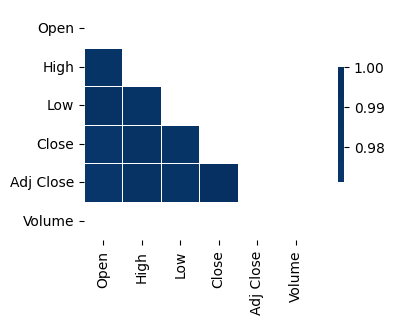

In [10]:
# Compute the correlation matrix
corr = df_raw.corr()
corr
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 3))

# Generate a custom diverging colormap
cmap = "RdBu"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

Before we get into our supervised learning, lets look at VIX vs SPY (the S&P500) index.  Using Seaborn library we can visualize a linear regression model that assumes a linear relationship between VIX as independent variable and SPY as the dependent variable.

We can find that smaller regression period shows a more linear relationship than the larger period.  Also there is inverse relationship between VIX and SPY.

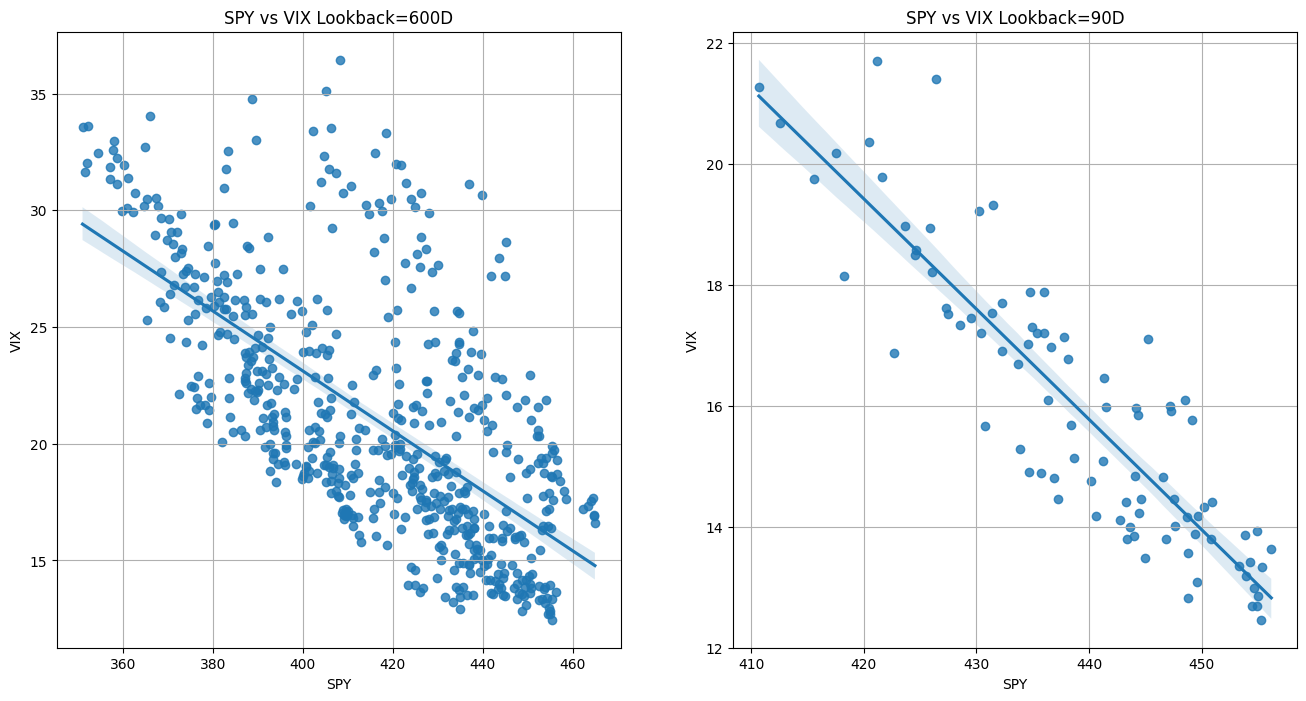

In [5]:

dfSPY = df_spy[['Adj Close']]
dfVIX = df_raw[['Adj Close']]
dfSPY.columns=['SPY']
dfVIX.columns=['VIX']

df=dfSPY.join(dfVIX).dropna()

# 600 Days
nDays=600
data=df.tail(nDays).copy()
fix,myAx = plt.subplots(1,2, figsize=(16,8),sharey=False)
ax=myAx[0]
ax.grid(True)
sns.regplot(data=data,x='SPY',y='VIX',ax=ax)
ax.set_title(f"SPY vs VIX Lookback={nDays}D")
ax.set_xlabel('SPY')
ax.set_ylabel('VIX')
ax.tick_params(axis='both', which='major')

# 90 Days
nDays=90
data=df.tail(nDays).copy()
ax=myAx[1]
ax.grid(True)
sns.regplot(data=data,x='SPY',y='VIX',ax=ax)
ax.set_title(f"SPY vs VIX Lookback={nDays}D")
ax.set_xlabel('SPY')
ax.set_ylabel('VIX')
plt.tick_params(axis='both', which='major')

#### Data augmentation

ta library allows to calculate all technical indicators including RSI, MACD, momentum etc and add them to the dataframe.  All these technical indicators are really helpful in making better decisions in our supervised learning. Instead of the current 7 columns, this will result in 92 columns

In [44]:
df_ta = df_raw.copy()
add_all_ta_features(df_ta, open="Open", high="High", low="Low", close="Adj Close", volume="Volume", fillna=True)
df_ta.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,16.040001,17.280001,15.940000,16.440001,16.440001,0,-0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,16.440001,0.000000,0.000000,0.000000
2018-12-04,16.840000,21.940001,16.260000,20.740000,20.740000,0,0.0,0,0.0,0.0,...,2.046839,0.409368,1.637471,0.0,0.0,0.0,17.801452,26.155712,23.234677,26.155712
2018-12-06,23.530001,25.940001,20.940001,21.190001,21.190001,0,0.0,0,0.0,0.0,...,3.767569,1.081008,2.686561,0.0,0.0,0.0,19.048006,2.169724,2.146521,28.892943
2018-12-07,22.420000,24.709999,19.900000,23.230000,23.230000,0,0.0,0,0.0,0.0,...,5.898896,2.044586,3.854310,0.0,0.0,0.0,20.768483,9.627178,9.191513,41.301696
2018-12-10,23.950001,25.940001,22.500000,22.639999,22.639999,0,0.0,0,0.0,0.0,...,7.155734,3.066815,4.088919,0.0,0.0,0.0,21.399290,-2.539820,-2.572630,37.712887


#### Preprocess data

We need to preprocess the data and change non-stationaries to stationaries.  A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. In general, a stationary time series will have no predictable patterns in the long-term. One way to make a non-stationary time series stationary is to compute the differences between consecutive observations. This is known as differencing.  We determine the change in percentage terms and use it

In [45]:
non_stationaries = []
for col in df.columns:
    try:
        #print(f'processing column {col}')    
        dft = adfuller(df[col])
        p_value = dft[1]
        t_test = dft[0] < dft[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
    except ValueError:
        non_stationaries.append(col)
        
print(f"Non-Stationary features found: {len(non_stationaries)}")

# Convert to stationaries
df_stationary = df_ta.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]


Non-Stationary Features Found: 2


####  Data cleaning

We dont want rows that have NaN or +infinity or -infinity.  These values will affect the outcomes and are invalid.  We dont have to check for visualization before dropping these values.  We could have created these values when we did ta because a lot of the parameters are calculated as avg or percent change etc.

In [46]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Adj Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-04,16.840000,21.940001,0.020075,20.740000,20.740000,0.0,0,0.0,0.0,0.0,...,2.046839,0.409368,1.637471,0.0,0.0,0.0,17.801452,26.155712,23.234677,26.155712
2018-12-06,23.530001,25.940001,0.287823,21.190001,21.190001,0.0,0,0.0,0.0,0.0,...,3.767569,1.081008,2.686561,0.0,0.0,0.0,19.048006,2.169724,2.146521,28.892943
2018-12-07,22.420000,24.709999,-0.049666,23.230000,23.230000,0.0,0,0.0,0.0,0.0,...,5.898896,2.044586,3.854310,0.0,0.0,0.0,20.768483,9.627178,9.191513,41.301696
2018-12-10,23.950001,25.940001,0.130653,22.639999,22.639999,0.0,0,0.0,0.0,0.0,...,7.155734,3.066815,4.088919,0.0,0.0,0.0,21.399290,-2.539820,-2.572630,37.712887
2018-12-11,22.959999,23.600000,-0.049333,21.760000,21.760000,0.0,0,0.0,0.0,0.0,...,7.643198,3.982092,3.661106,0.0,0.0,0.0,21.497689,-3.886922,-3.964479,32.360094


#### Train and Test data split

We will be using 70% of the data for testing, and the rest (30%) will be used for training since we have enough rows


In [17]:
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Adj Close"].shift(-1) > df_stationary["Adj Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [18]:
# Split Target from Featureset
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [19]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [20]:
# Train Test Split
# test_size=0.7 means 70% of the data will be used for testing, and the rest (20%) will be used for training

X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

#### Supervised learning using RandomForest

While other supervised classification methods exist, choosing a simple model didnt result in good test accuracy.  So, we need to choose techniques like RandomForest or XGBoost to have a good chance at getting better outcomes

In [21]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.5483503981797497
Test Precision: 0.55


In [22]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.55490463, 0.44509537],
       [0.38842528, 0.61157472],
       [0.59333912, 0.40666088],
       ...,
       [0.67212568, 0.32787432],
       [0.61909011, 0.38090989],
       [0.6528633 , 0.3471367 ]])

The number of estimators chosen above (12) is arrived at after checking various values.  But let us look at the process to arrive at the number.

In [23]:
# Test for Overfitting and find right number for estimators
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)
    

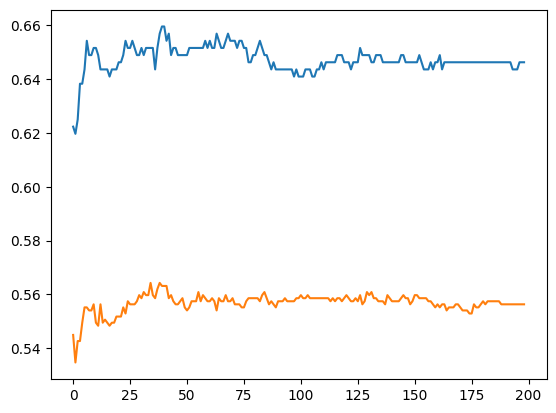

In [24]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

#### Result evaluation
The overall accuracy is around 54.8% and precision is around 55%.  Our ability to predict if the next day's volatility is higher or lower is not very encouraging.  We can however dig more into the probability and choose to use the result only when the probability is very high.  This will help reduce the chance of placing trades based on just the result/outcome. 

#### Performance Evaluation - Confusion Matrix

We seem to be identifying more 0s than 1s and the predictability of 0 is better i.e., prediting 0 and that being true is higher

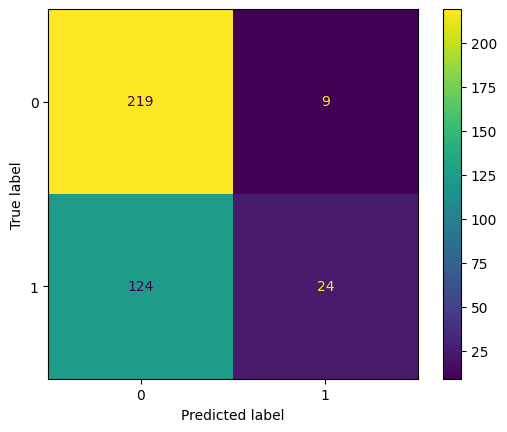

In [27]:
# training confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train).plot()

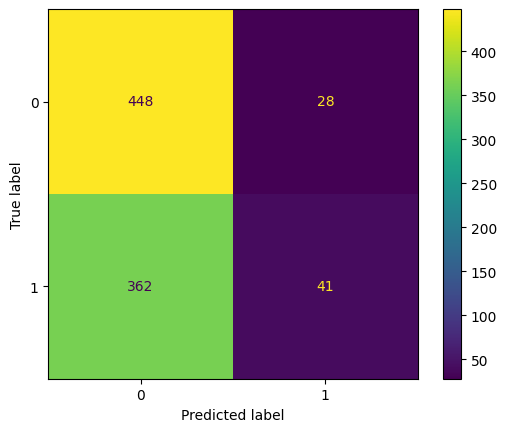

In [28]:
# test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test).plot()

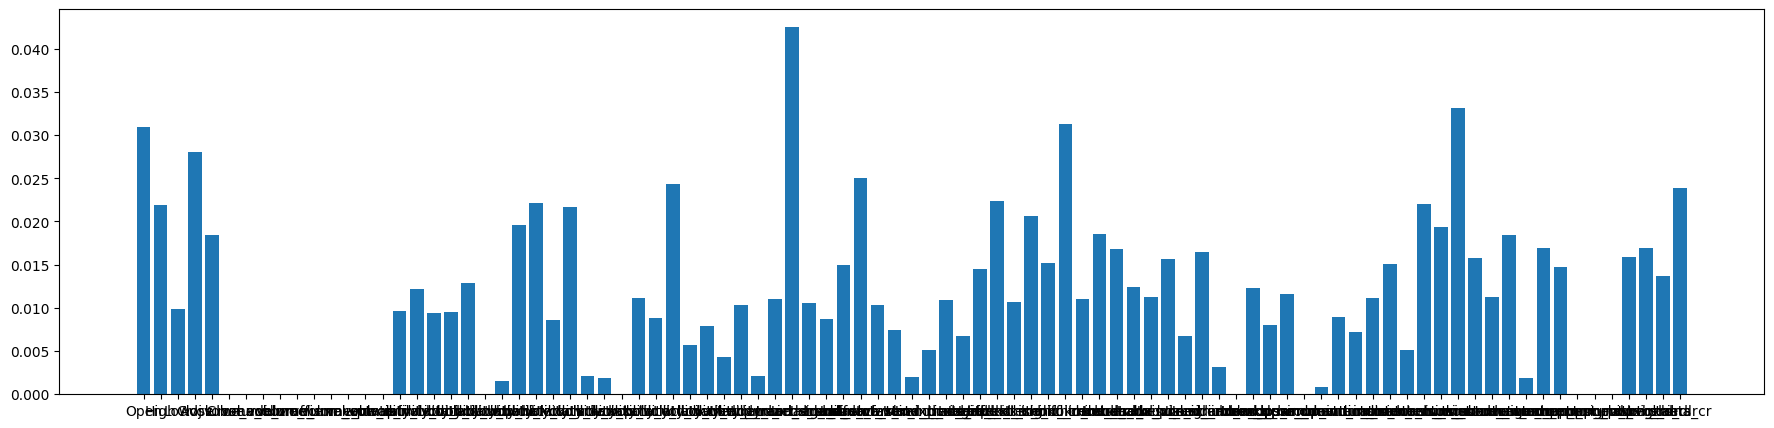

In [29]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features =classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

#### Conclusion/ Lessons learned

The prediction results, while good, are not good enough to be used in production.  There is a lot more desired to make this consumable.
This project helped me apply the skills learned in the class and appreciate the topics.  

Some of the lessons learned:
* Data is not free - especially financial data
* There are enough python libraries that can help augment financial data
* Applying a general model without any "alpha" (something different that can give better results) doesnt really help a lot with the final results.  Part of this may be due to markets being susceptible to various news including war and pandemics

#### Future work/improvements

1. We could look at adding a bigger date range to see if the results are better
2. We could play with the test and training data split to see if that can provide better accuracy
3. We could explore other supervised techniques to see if we can arrive at a better prediction
4. We could explore other data or augmented data or even apply market sentiment using NLP and use that as a parameter

#### References
1. VIX: https://www.investopedia.com/terms/v/vix.asp
2. S&P500: https://www.investopedia.com/terms/s/sp500.asp
3. yfinance: https://github.com/ranaroussi/yfinance